# Import stuff

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels
import statsmodels.stats
import statsmodels.stats.proportion
import numpy as np
from scipy.stats import norm

pd.options.display.max_columns = None

## Define functions

In [24]:
# set random seed for repeatable results for random sampling
#np.random.seed(1213145)
# this does the resampling for sample distributions
def CLM_resampler(distribution, sample_size, num_samples):
    np.random.seed(1213145)
    sample_means = np.zeros(num_samples)
    pop_std = distribution.std()
    for idx, num in enumerate(range(num_samples)):
        sample = np.random.choice(distribution, size=sample_size, replace=True)
        sample_means[idx] = sample.mean()
    return sample_means

In [12]:
# calculates proportion of delayed or cancelled flights given our dataframe - very narrow scope for this function, easy to break
def calc_prop(df, prop_type):
    if prop_type == 'cancelled':
        df_can = df.loc[(df.CANCELLATION_CODE=='A'),:].shape[0]
        df_nobs_can = df.shape[0]
        df_proportion_can = df_can/df_nobs_can
        return df_proportion_can, df_nobs_can, df_can
    elif prop_type == 'delayed':
        df_del = df.loc[((df.CARRIER_DELAY>0) & (df.CANCELLED==0)),:].shape[0]
        df_nobs_del = df.loc[(df.CANCELLED==0),:].shape[0]
        df_proportion_del = df_del/df_nobs_del
        return df_proportion_del, df_nobs_del, df_del
    else:
        return 'input in second argument must be either "cancelled" or "delayed"'

# Download data

In [4]:
airline_names_key = pd.read_csv('flight_data_zipped_files/airline_name_and_code_key.zip', names = ['OP_UNIQUE_CARRIER', 'CARRIER_NAME'])

april = pd.read_csv('flight_data_zipped_files/april_2019.zip')
march = pd.read_csv('flight_data_zipped_files/march_2019.zip')
february = pd.read_csv('flight_data_zipped_files/february_2019.zip')
january = pd.read_csv('flight_data_zipped_files/january_2019.zip')
december = pd.read_csv('flight_data_zipped_files/december_2018.zip')
november = pd.read_csv('flight_data_zipped_files/november_2018.zip')

C:\Users\prayt\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Organize data into useable df's

In [5]:
frames = [april, march, february, january, december, november]
df = pd.concat(frames)
df = df.merge(airline_names_key, how='left', on='OP_UNIQUE_CARRIER')

#### This is a huge dataframe.  dropping some columns we don't need to speed things up. 

In [6]:
lean_df = df.drop(columns = ['QUARTER', 'OP_CARRIER_AIRLINE_ID','TAIL_NUM', 'OP_CARRIER_FL_NUM', 'DEST_WAC', 'DEST_STATE_FIPS', 'ORIGIN_CITY_MARKET_ID', 'Unnamed: 55', 'FIRST_DEP_TIME', 'ARR_TIME_BLK', 'DEST_AIRPORT_SEQ_ID', 'DEST_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_AIRPORT_ID'])

There are missing values wherever flight was cancelled - something to watch out for

#### Create new df for only American Airlines and Not American Airlines

In [7]:
AA_df = lean_df.loc[(lean_df.CARRIER_NAME=='American Airlines Inc.'),:]
not_AA_df = lean_df.loc[(lean_df.CARRIER_NAME!='American Airlines Inc.')]
# everyone but american/delta/southwest/united
not_top_4_df = lean_df.loc[((lean_df.CARRIER_NAME!='American Airlines Inc.')|(lean_df.CARRIER_NAME!='United Air Lines Inc.')|(lean_df.CARRIER_NAME!='Southwest Airlines Co.')|(lean_df.CARRIER_NAME=='Delta Air Lines Inc.'))]
# delta/united/southwest
top_3_df = lean_df.loc[((lean_df.CARRIER_NAME=='Delta Air Lines Inc.')|(lean_df.CARRIER_NAME=='United Air Lines Inc.')|(lean_df.CARRIER_NAME=='Southwest Airlines Co.'))]

calc num cancellations

# Graph cancelled flights AA v Top 3 v All others

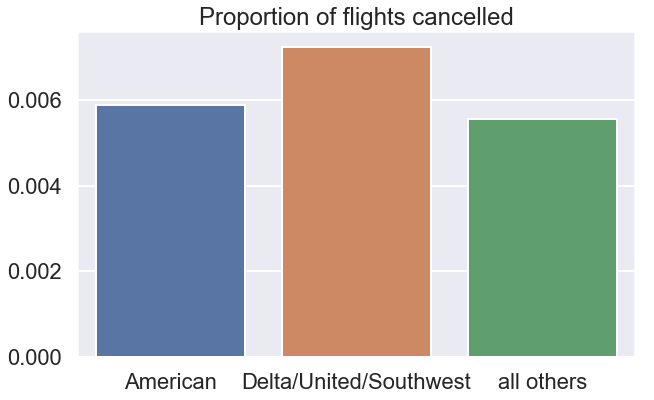

In [13]:
top_3_prop = calc_prop(top_3_df, 'cancelled')
AA_prop = calc_prop(AA_df, 'cancelled')
not_AA_prop = calc_prop(not_AA_df, 'cancelled')
not_top_4_prop = calc_prop(not_top_4_df, 'cancelled')

plt.figure(figsize=(10,6))
sns.barplot(['American', 'Delta/United/Southwest', 'all others'], [AA_prop[0], top_3_prop[0], not_top_4_prop[0]]).set_title('Proportion of flights cancelled')
sns.set(context='poster')
plt.savefig('proportion_flights_cancelled_AA_Top3')

# Graph delayed flights

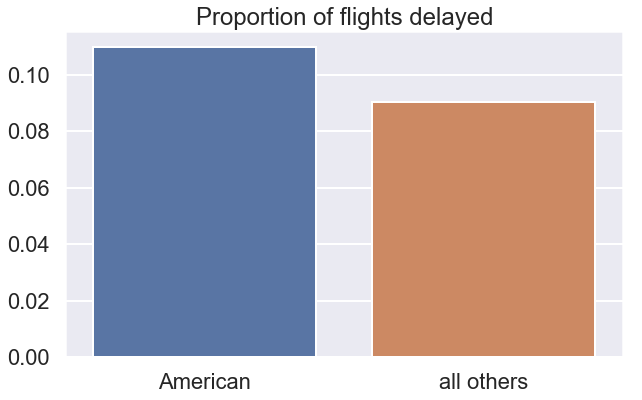

In [14]:
## proportions are commented out - these will be calculated in the t-test and are not needed.  
AA_prop_delay = calc_prop(AA_df, 'delayed')
not_AA_prop_delay = calc_prop(not_AA_df, 'delayed')
top_3_prop_delay = calc_prop(top_3_df, 'delayed')
not_top_4_prop_delay = calc_prop(not_top_4_df, 'delayed')

plt.figure(figsize=(10,6))
sns.barplot(['American', 'all others'], [AA_prop_delay[0], not_AA_prop_delay[0]]).set_title('Proportion of flights delayed')
sns.set(context='poster')

# Graph proportion delayed flights American v top 3 v all others

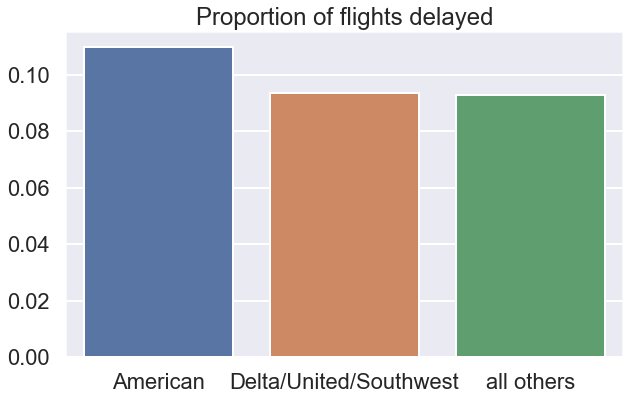

In [15]:

plt.figure(figsize=(10,6))
sns.barplot(['American', 'Delta/United/Southwest', 'all others'], [AA_prop_delay[0], top_3_prop_delay[0], not_top_4_prop_delay[0]]).set_title('Proportion of flights delayed')
sns.set(context='poster')

# Proportions Z-Test! Now we get to the good stuff!

In [11]:
AA_prop_delay[0],not_AA_prop_delay[0], AA_prop_delay[1],not_AA_prop_delay[1]

(0.10998516556172849, 0.09053454234433653, 446933, 3022305)

In [16]:
zstat, pvalue = statsmodels.stats.proportion.proportions_ztest(count=[AA_prop_delay[2],not_AA_prop_delay[2]], nobs=[AA_prop_delay[1],not_AA_prop_delay[1]])
zstat, pvalue

(41.78084798936522, 0.0)

P is approximatley zero so reject the null - difference between two proportions is significant. 

# Moving on to anova for delays at DC area airports DCA/IAD/BWI
Are cancellation rates uniform across airports?  

# Create dfs for Anova

##### Select data airport specific american airlines data

In [18]:
# these come from already existing AA_df dataframe generated above
DCA = lean_df.loc[((lean_df.ORIGIN=='DCA')&(lean_df.CANCELLED==0)&(lean_df.DEP_DELAY_NEW>=15)&(lean_df.CARRIER_DELAY>0)&(lean_df.CARRIER_NAME=='American Airlines Inc.'))]
IAD = lean_df.loc[((lean_df.ORIGIN=='IAD')&(lean_df.CANCELLED==0)&(lean_df.DEP_DELAY_NEW>=15)&(lean_df.CARRIER_DELAY>0)&(lean_df.CARRIER_NAME=='American Airlines Inc.'))]
BWI = lean_df.loc[((lean_df.ORIGIN=='BWI')&(lean_df.CANCELLED==0)&(lean_df.DEP_DELAY_NEW>=15)&(lean_df.CARRIER_DELAY>0)&(lean_df.CARRIER_NAME=='American Airlines Inc.'))]

# Anova

In [35]:
DCA_s = CLM_resampler(DCA.CARRIER_DELAY, 100, 1000)
IAD_s = CLM_resampler(IAD.CARRIER_DELAY, 100, 1000)
BWI_s = CLM_resampler(BWI.CARRIER_DELAY, 100, 1000)

print('DCA mean = ' + str(DCA_s.mean()) + ',IAD mean = ' + str(IAD_s.mean()) + ' BWI mean = '+ str(BWI_s.mean()))

resultsD_I = stats.kruskal(DCA_s, IAD_s)
resultsD_B = stats.kruskal(DCA_s, BWI_s)
resultsB_I = stats.kruskal(DCA_s, BWI_s)

print('DCA/IAD' + str(resultsD_I) + ', DCA/BWI' + str(resultsD_B) + ', BWI/IAD' + str(resultsB_I))

DCA mean = 55.435790000000004,IAD mean = 74.15111999999999 BWI mean = 64.98985
DCA/IADKruskalResult(statistic=653.0380242526505, pvalue=4.879812257783986e-144), DCA/BWIKruskalResult(statistic=205.34620582193662, pvalue=1.4231310639953818e-46), BWI/IADKruskalResult(statistic=205.34620582193662, pvalue=1.4231310639953818e-46)


#### Check for homoscedasticity 

This appears to fail levene test for equal variance.  Bah.  Looks like we can't assume that.

we'll use Kruskal-Wallis H-test instead - this is non parametric version of one-way anova test.  

In [36]:
stats.levene(DCA_s, IAD_s, BWI_s)

LeveneResult(statistic=172.3702973947823, pvalue=1.386569927973114e-71)

can't find a function for post-hoc that does not assume equal variance.  Will check for differences between the airports using Kruskal_Wallis for expediency. 

# Graph individual dlay distributions for airports

KruskalResult(statistic=653.0380242526505, pvalue=4.879812257783986e-144)
Ttest_indResult(statistic=-30.170335687276918, pvalue=7.860622732322519e-156)
KruskalResult(statistic=205.34620582193662, pvalue=1.4231310639953818e-46)
Ttest_indResult(statistic=-16.63457675667474, pvalue=2.762560888484923e-57)
KruskalResult(statistic=142.42632218685978, pvalue=7.846293143317372e-33)
Ttest_indResult(statistic=-12.205968464235093, pvalue=4.327030763796551e-33)


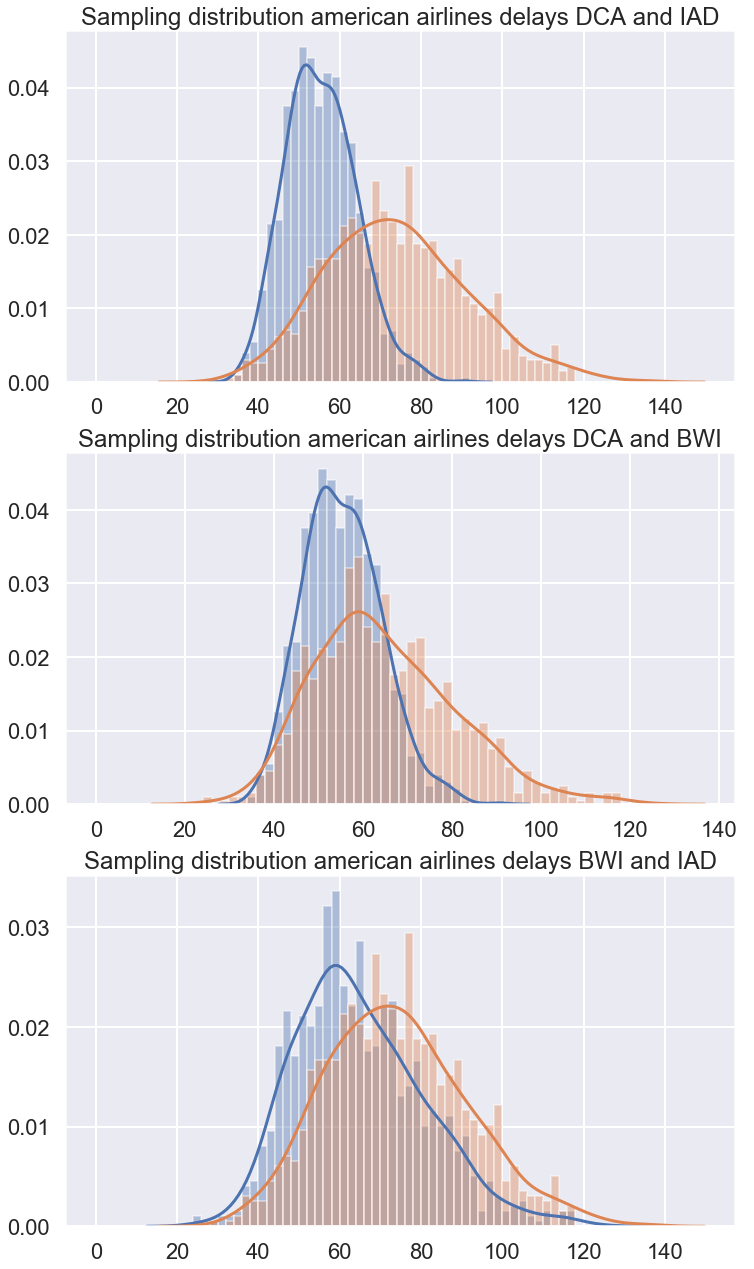

In [38]:
plt.figure(figsize=(12,22))

print(stats.kruskal(DCA_s, IAD_s))
print(stats.ttest_ind(DCA_s, IAD_s, equal_var=False))
plt.subplot(311)
ax1 = sns.distplot(DCA_s, bins=range(0,120,2))
ax1 = sns.distplot(IAD_s, bins=range(0,120,2))
ax1.set_title('Sampling distribution american airlines delays DCA and IAD')


plt.subplot(312)
print(stats.kruskal(DCA_s, BWI_s))
print(stats.ttest_ind(DCA_s, BWI_s, equal_var=False))
ax2 = sns.distplot(DCA_s, bins=range(0,120,2))
ax2 = sns.distplot(BWI_s, bins=range(0,120,2))
ax2.set_title('Sampling distribution american airlines delays DCA and BWI')


plt.subplot(313)
print(stats.kruskal(BWI_s, IAD_s))
print(stats.ttest_ind(BWI_s, IAD_s, equal_var=False))
ax3 = sns.distplot(BWI_s, bins=range(0,120,2))
ax3 = sns.distplot(IAD_s, bins=range(0,120,2))
ax3.set_title('Sampling distribution american airlines delays BWI and IAD')

plt.savefig('sampling_distribution_airport_subplots.jpg')

# Graph delay dist all airports

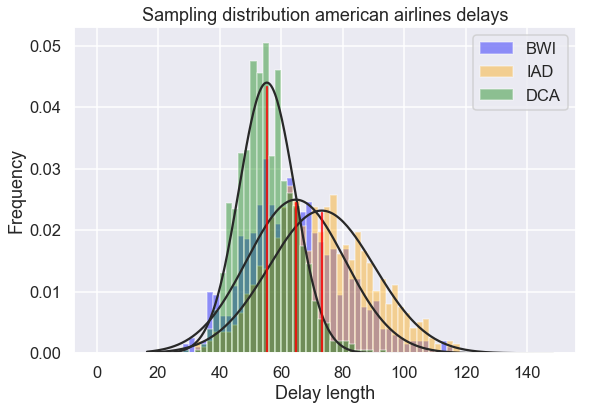

In [248]:
plt.figure(figsize=(9,6))
#sns.set(context='talk')
ax = sns.distplot(BWI_s, bins=range(0,120,2), label='BWI', color='blue', kde=False, fit=norm)
ax = sns.distplot(IAD_s, bins=range(0,120,2), label='IAD', color='orange', kde=False, fit=norm)
ax = sns.distplot(DCA_s, bins=range(0,120,2), label='DCA', color='green', kde=False, fit=norm)
ax.set_title('Sampling distribution american airlines delays')
ax.set(xlabel='Delay length', ylabel='Frequency')
ax.legend()
plt.axvline(DCA_s.mean(), 0, .815, color='red', alpha=.8)
plt.axvline(IAD_s.mean(), 0, .43, color='red', alpha=.8)
plt.axvline(BWI_s.mean(), 0, .46, color='red', alpha=.8)

plt.savefig('american_specific_airport_delays_sample_dist.jpg')

Results are significant all three airports are different from eachother

# Plot customer ratings

(0, 10)

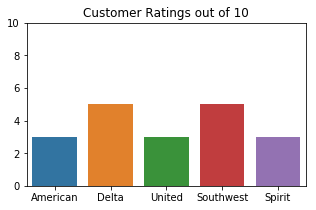

In [3]:
airline=['American','Delta','United','Southwest', 'Spirit']
ratings=[3,5,3,5,3]

plt.figure(figsize=(5,3))

sns.barplot(airline, ratings).set_title('Customer Ratings out of 10')
plt.ylim(0,10)
plt.savefig('ratings')